<h2><center><font color='red'> Krigging

In [118]:
# Import libraries
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib_map_utils as mapu # for North Arrow
from matplotlib_scalebar.scalebar import ScaleBar # to draw scalebar
from pykrige.ok import OrdinaryKriging
from pykrige.kriging_tools import write_asc_grid
from sklearn.linear_model import LinearRegression
from mpl_toolkits.mplot3d import Axes3D

In [119]:
# Read files
fname = 'Trimble_Final_Data.csv'
a = pd.read_csv(fname)
a.head()

,Img_Label,X,Y,Z,Hor_Accuracy,Ver_Accuracy,Remarks
0,A,396103.8633,3323564.158,4.425630,0.10,0.10,Concrete Top Left
1,B,396136.7596,3323564.703,4.492191,0.10,0.10,Concrete Top Right
2,C,396136.4109,3323541.640,5.300878,0.23,0.22,Concrete Bottom Right
3,D,396103.5592,3323540.882,4.571488,0.13,0.15,Concrete Bottom Left
4,F1,396123.5924,3323552.059,4.698696,0.10,0.10,Field Point 1


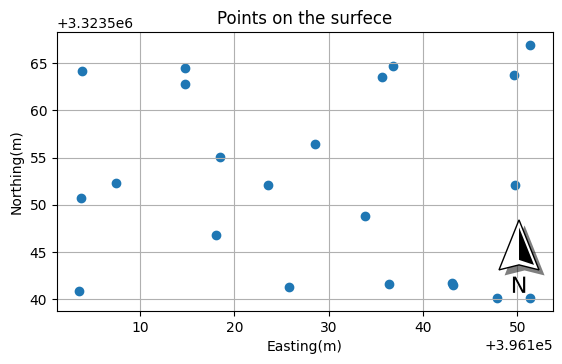

In [120]:
# Create a geometry column from the longitude and latitude columns
jeffa = gpd.GeoDataFrame(a, geometry=gpd.points_from_xy(a.X, a.Y))
jeffa.crs = 'EPSG:26915'  
jeffa.head()

#Plotting
fig,ax = plt.subplots()
jeffa.plot(ax=ax)
plt.grid()
mapu.north_arrow.north_arrow(ax=ax, location="lower right", rotation={"degrees":0})
plt.xlabel('Easting(m)')
plt.ylabel('Northing(m)')
plt.title('Points on the surfece')
plt.show()


In [121]:
#Boundaries for grid
x = list(jeffas.geometry.x)
y = list(jeffas.geometry.y)
z = list(jeffas.Z)
# Get the bounds of Jefferson county to create a grid of size delta
delta = 1 
xmin, ymin, xmax, ymax = jeffas.total_bounds
print(xmin, ymin, xmax,ymax)
gridx = np.arange(xmin,(xmax+delta),delta)
gridy = np.arange(ymin,(ymax+delta),delta)


396103.5592 3323540.109 396151.3764 3323566.964


In [122]:
#Validate Input Data
x, y, z = np.array(x), np.array(y), np.array(z)
if len(x) == 0 or len(y) == 0 or len(z) == 0:
    raise ValueError("Input arrays x, y, and z cannot be empty.")
if len(x) != len(y) or len(x) != len(z):
    raise ValueError("Input arrays x, y, and z must have the same length.")
mask = ~np.isnan(x) & ~np.isnan(y) & ~np.isnan(z)
x, y, z = x[mask], y[mask], z[mask]

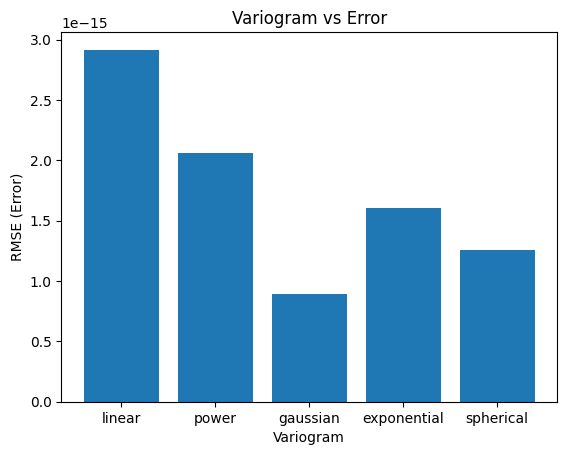

In [123]:
# Perform ordinary Kriging and evaluate variogram models
models = ['linear', 'power', 'gaussian', 'exponential', 'spherical']
varioerr = []

for m in models:
    try:
        ok = OrdinaryKriging(x, y, z, variogram_model=m, verbose=False, enable_plotting=False)
        Aspred, ss = ok.execute("points", x, y) 
        err = np.nansum((z - Aspred.ravel())**2)
        rmse = np.sqrt(err / len(z))
        varioerr.append(rmse)
    except Exception as e:
        print(f"Model {m} failed with error: {e}")
        varioerr.append(np.nan)  

models = [m for m, v in zip(models, varioerr) if not np.isnan(v)]
varioerr = [v for v in varioerr if not np.isnan(v)]

# Plot the error profile
minlim = np.min(varioerr) - np.std(varioerr)
maxlim = np.max(varioerr) + np.std(varioerr)
plt.bar(models, varioerr)
plt.ylabel('RMSE (Error)')
plt.xlabel('Variogram')
plt.title('Variogram vs Error')
plt.show()

In [124]:
#Perform ordinary kriging with Spherical Model (best fit model)
ok = OrdinaryKriging(
    x, y, z,
    variogram_model='spherical',
    verbose=True,
    enable_plotting=False
)

z_pred, ss_pred = ok.execute('grid', gridx, gridy)
lags = ok.lags 
semivariance = ok.semivariance  
model_parameters = ok.variogram_model_parameters
sill = model_parameters[0]
range_ = model_parameters[1]
nugget = model_parameters[2]

Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'spherical' Variogram Model
Partial Sill: 0.04978331385683893
Full Sill: 0.12042053827424126
Range: 0.8549420916262509
Nugget: 0.07063722441740233 

Calculating statistics on variogram model fit...
Executing Ordinary Kriging...



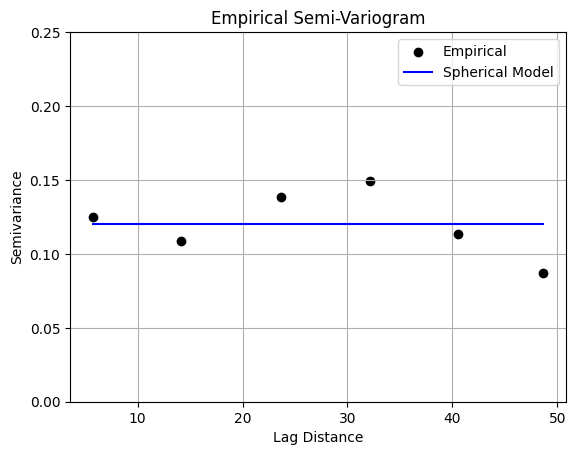

In [125]:
def spherical_variogram(h, sill, range_, nugget):
    h = np.array(h)
    gamma = np.zeros_like(h)
    mask = h <= range_  
    gamma[mask] = nugget + sill * (1.5 * (h[mask] / range_) - 0.5 * (h[mask] / range_) ** 3)
    gamma[~mask] = nugget + sill 
    return gamma

lags = ok.lags  
semivariance = ok.semivariance  
theoretical_variogram = spherical_variogram(lags, sill, range_, nugget)

#Plot
plt.figure()
plt.scatter(lags, semivariance, color='black', label='Empirical')
plt.plot(lags, theoretical_variogram, color='blue', label='Spherical Model')
plt.xlabel('Lag Distance')
plt.ylabel('Semivariance')
plt.title('Empirical Semi-Variogram')
plt.ylim(0, 0.25) 
plt.grid()
plt.legend()
plt.show()

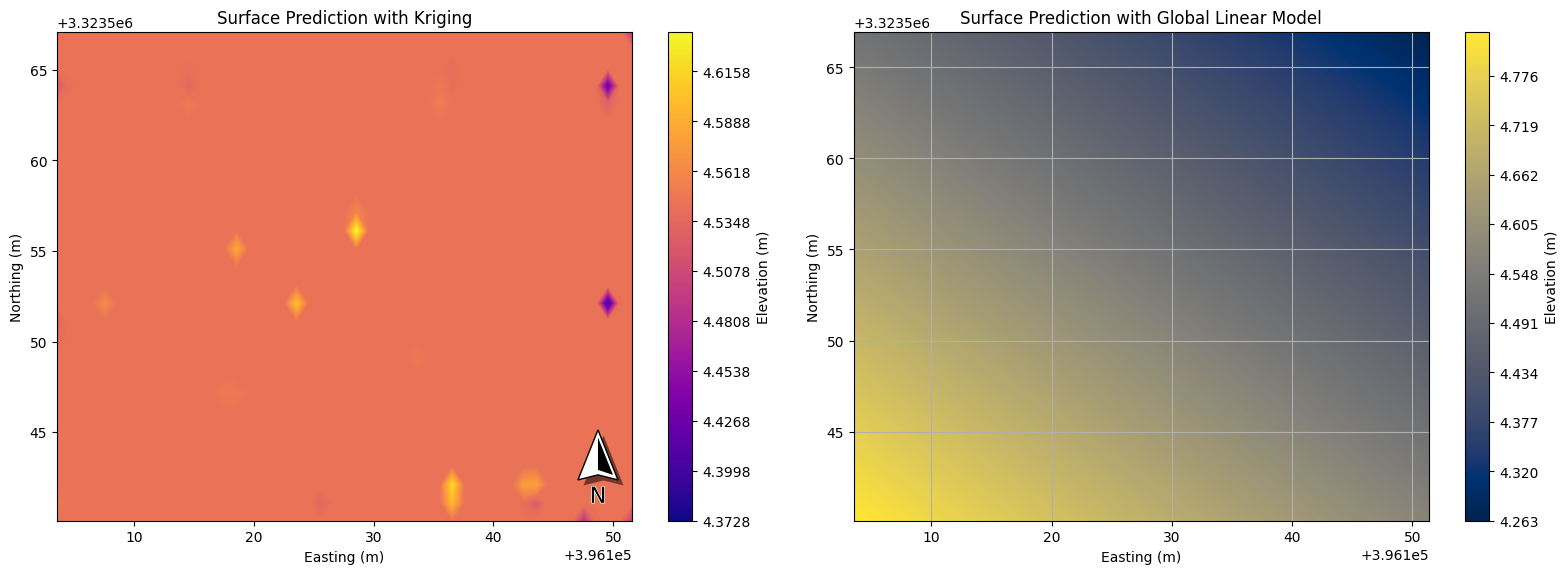

In [126]:
# Step 8: Plot the predicted surface with Kriging and the global linear model
x_vals = np.linspace(x_coords.min(), x_coords.max(), 100)
y_vals = np.linspace(y_coords.min(), y_coords.max(), 100)
x_mesh, y_mesh = np.meshgrid(x_vals, y_vals)

# Fit a linear regression model for the global surface prediction
regressor = LinearRegression()
regressor.fit(np.column_stack((x_coords, y_coords)), z_coords)
global_predictions = regressor.predict(np.column_stack((x_mesh.ravel(), y_mesh.ravel())))
global_predictions = global_predictions.reshape(x_mesh.shape)

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Kriging model surface plot
kriging_plot = axes[0].contourf(grid_x, grid_y, predicted_surface, levels=500, cmap='plasma')
map_tools.north_arrow.north_arrow(ax=axes[0], location="lower right", rotation={"degrees": 0})
fig.colorbar(kriging_plot, ax=axes[0], label='Elevation (m)')
axes[0].set_title('Surface Prediction with Kriging')
axes[0].set_xlabel('Easting (m)')
axes[0].set_ylabel('Northing (m)')

# Global model surface plot
global_plot = axes[1].contourf(x_mesh, y_mesh, global_predictions, levels=500, cmap='cividis')
fig.colorbar(global_plot, ax=axes[1], label='Elevation (m)')
axes[1].set_title('Surface Prediction with Global Linear Model')
axes[1].set_xlabel('Easting (m)')
axes[1].set_ylabel('Northing (m)')
axes[1].grid(True)

# Adjust layout for optimal display
plt.tight_layout()


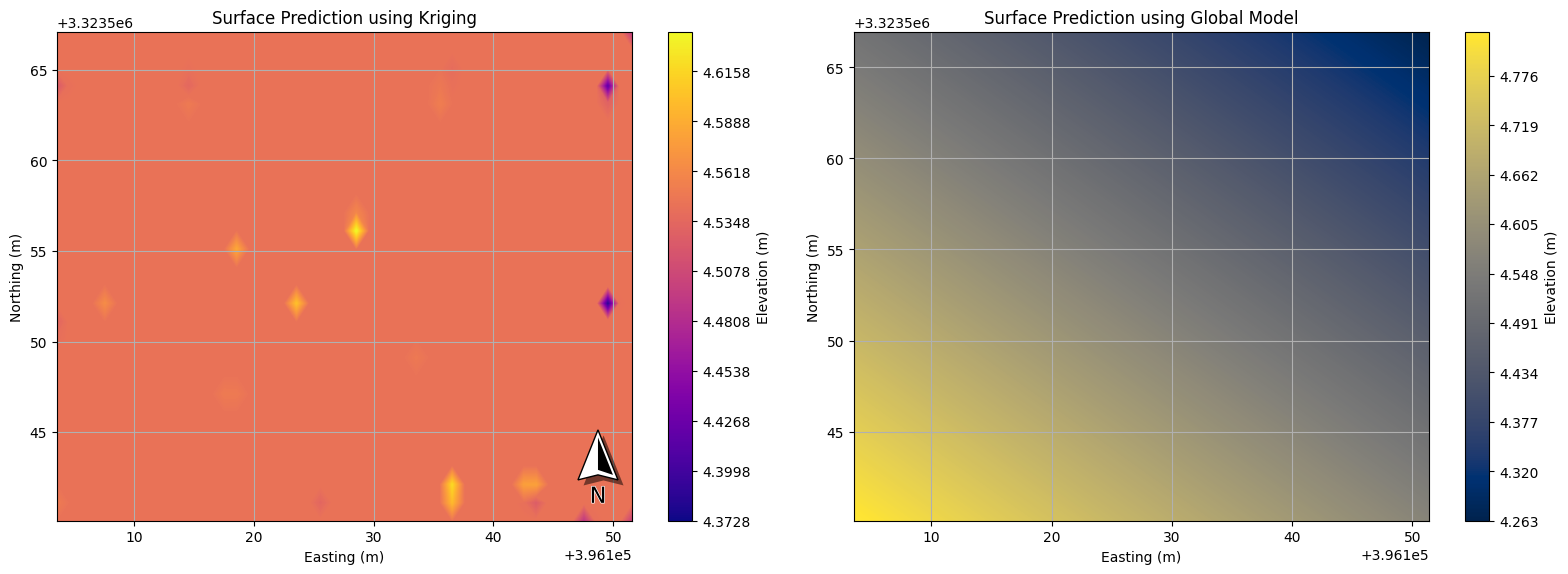

In [127]:
# Train a linear regression model to predict the global surface
regressor = LinearRegression()
regressor.fit(np.column_stack((x_coords, y_coords)), z_coords)

# Predict the values using the global model
global_predictions = regressor.predict(np.column_stack((x_mesh.ravel(), y_mesh.ravel())))
global_predictions = global_predictions.reshape(x_mesh.shape)

# Create a figure with two subplots for visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Kriging model surface plot
kriging_contour = axes[0].contourf(grid_x, grid_y, predicted_surface, levels=500, cmap='plasma')
map_tools.north_arrow.north_arrow(ax=axes[0], location="lower right", rotation={"degrees": 0})
fig.colorbar(kriging_contour, ax=axes[0], label='Elevation (m)')
axes[0].set_title('Surface Prediction using Kriging')
axes[0].set_xlabel('Easting (m)')
axes[0].set_ylabel('Northing (m)')
axes[0].grid(True)

# Global model surface plot
global_contour = axes[1].contourf(x_mesh, y_mesh, global_predictions, levels=500, cmap='cividis')
fig.colorbar(global_contour, ax=axes[1], label='Elevation (m)')
axes[1].set_title('Surface Prediction using Global Model')
axes[1].set_xlabel('Easting (m)')
axes[1].set_ylabel('Northing (m)')
axes[1].grid(True)

# Adjust layout for better display and show the plots
plt.tight_layout()
plt.show()


<h4> Compare Kriging Model vs Global Model Predictions

The Kriging model provides a spatially accurate prediction with detailed variations in surface elevation. The global model provides a smoother surface, assuming a uniform trend across the entire region. It does not capture the fine-scale spatial variability that the Kriging model does.

Kriging outperforms the Global Linear Model for spatially variable data like surface elevations. Kriging takes spatial correlations into account, which is important for geospatial data. It provides not only predictions but also the standard error, which helps in assessing the reliability of prediction

<h4> Where to Sample Nextime

If I were to collect additional data, I would focus on regions with high standard error values from the Kriging model, typically around the edges or areas with sparse data.

Sampling in these areas would improve the prediction accuracy, as the Kriging model relies on nearby data points to make predictions. By filling gaps in sparse areas, the model would have better data coverage and reduce uncertainty.